# Setup

In [1]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots

# Three node network

In [2]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [61]:
function additive_noise!(du,u,p,t)
    s,g,b,ϕ = p
    for i = 1:length(u)
        #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
        du[i] = ϕ 
    end
end

function network_model!(du,u,p,t)
    s,g,b,ϕ = p
    
    # Specifying task within the model to avoid adding it as a parameter in p
    ts = 1:1:Tmax
    task = repeat([0.0], 100)
#     task[4] = 1 #without impulse it'd be "resting state"
    I = LinearInterpolation(ts, task, extrapolation_bc = 0)
    
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + b*I(t)
    end
end

network_model! (generic function with 1 method)

In [62]:
num_nodes = 3
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)

W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]
dt = 0.5

# s = 0.3
# g = 0.7
# b = 0.5
# ϕ = 0.1

p = [0.3, 0.7, 0.5, 0.01]

prob_sde = SDEProblem(network_model!,additive_noise!,u0,tspan,p)


SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

In [63]:
# sol = solve(prob_sde, dt=dt, adaptive=false)
# plot(sol)

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

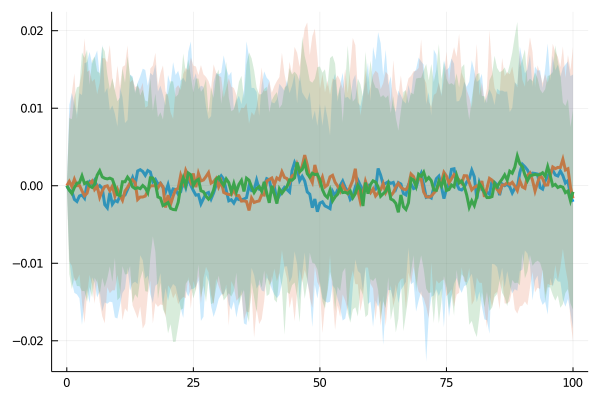

In [64]:
ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(), trajectories=50, dt=dt, adaptive=false)
plot(EnsembleSummary(data))

In [94]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob)
    σ ~ InverseGamma(2,3)
    ϕ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
#     s = 0.3
#     g = 0.7
#     b = 0.0
    s ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    g ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    b ~ truncated(Normal(0.0,1.0),-3.0,3.0)

    p = [s,g,b,ϕ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],σ) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [95]:
model = fit_nmm(data, prob_sde)

DynamicPPL.Model{var"#31#32",(:data, :prob),(),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},

In [ ]:
@time vi_out = vi(model, ADVI(10, 1000))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 8909871377216795892
└ @ AdvancedVI /Users/zeynepenkavi/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing... 11%  ETA: 0:05:44

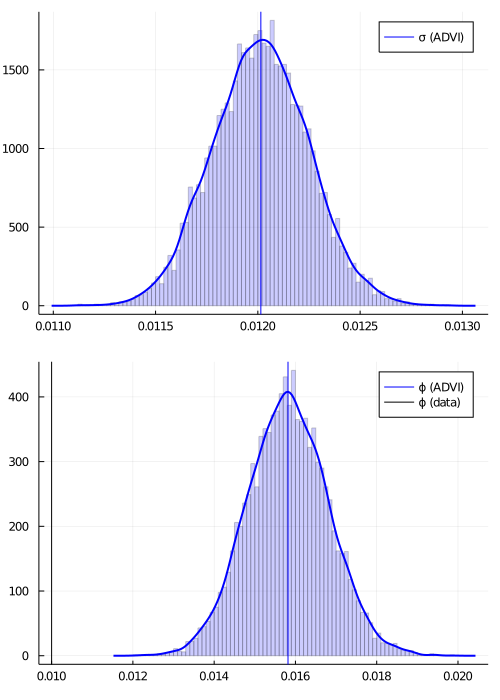

In [70]:
samples = rand(vi_out, 10000)

p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
# vline!([var(x)], label = "σ (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "ϕ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "ϕ (data)", color = :black)
vline!([mean(samples[2, :])], color = :blue, label ="")

p3 = histogram(samples[3, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[3, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[2]], label = "s (data)", color = :black)
vline!([mean(samples[3, :])], color = :blue, label ="")

p4 = histogram(samples[4, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[4, :], label = "g (ADVI)", color = :blue, linewidth = 2)
vline!([p[3]], label = "g (data)", color = :black)
vline!([mean(samples[4, :])], color = :blue, label ="")

p5 = histogram(samples[5, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[5, :], label = "b (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "b (data)", color = :black)
vline!([mean(samples[5, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, p5, layout=(5,1), size=(500, 700))

In [82]:
_, sym2range = Variational.bijector(model; sym_to_ranges = Val(true));
sym2range

LoadError: MethodError: objects of type Module are not callable

In [93]:
varinfo = DynamicPPL.VarInfo(model)
num_params = sum([size(varinfo.metadata[sym].vals, 1)
                      for sym ∈ keys(varinfo.metadata)])
dists = vcat([varinfo.metadata[sym].dists for sym ∈ keys(varinfo.metadata)]...)

num_ranges = sum([length(varinfo.metadata[sym].ranges)
                      for sym ∈ keys(varinfo.metadata)])
ranges = Vector{UnitRange{Int}}(undef, num_ranges)
idx = 0
range_idx = 1

sym_lookup = Dict{Symbol, Vector{UnitRange{Int}}}()
for sym ∈ keys(varinfo.metadata)
    sym_lookup[sym] = Vector{UnitRange{Int}}()
    for r ∈ varinfo.metadata[sym].ranges
        ranges[range_idx] = idx .+ r
        push!(sym_lookup[sym], ranges[range_idx])
        range_idx += 1
    end

    idx += varinfo.metadata[sym].ranges[end][end]
end

bs = Bijectors.bijector.(tuple(dists...))

Bijectors.Stacked(bs, ranges),
            (; collect(zip(keys(sym_lookup), values(sym_lookup)))...)

(Stacked{Tuple{Bijectors.Log{0},Bijectors.TruncatedBijector{0,Float64,Float64}},2}((Bijectors.Log{0}(), Bijectors.TruncatedBijector{0,Float64,Float64}(-3.0, 3.0)), (1:1, 2:2)), (σ = UnitRange{Int64}[1:1], ϕ = UnitRange{Int64}[2:2]))

In [ ]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob)
    σ ~ InverseGamma(2,3)
    ϕ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    s = 0.3
    g = 0.7
    b = 0.0
#     s ~ truncated(Normal(0.0,1.0),-3.0,3.0)
#     g ~ truncated(Normal(0.0,1.0),-3.0,3.0)
#     b ~ truncated(Normal(0.0,1.0),-3.0,3.0)

    p = [s,g,b,ϕ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],σ) #generate 3 points at a time for each node
        end
    end
end;

model = fit_nmm(data, prob_sde)

@time vi_out = vi(model, ADVI(10, 1000))

samples = rand(vi_out, 10000)

p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "s (data)", color = :black)
vline!([mean(samples[2, :])], color = :blue, label ="")

plot(p1, p2, layout=(2,1), size=(500, 700))


In [ ]:
# @time chain = sample(model, NUTS(), 500)
# plot(chain)
